In [1]:
from pyemma.msm import MaximumLikelihoodMSM, BayesianMSM, MaximumLikelihoodHMSM, its
from bhmm import lag_observations
import pyemma.plots as mplt
import pyemma.coordinates as coor
from msmbuilder.cluster import NDGrid
from sklearn.pipeline import Pipeline
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import entropy
import pandas as pd

/Users/robert_arbon/Google Drive/Research/PyEMMA/pyemma/__init__.py:111: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.2, you have 2.4+906.gaef6a90c.dirty.
  .format(latest=latest, current=current), category=UserWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 

In [2]:
def bic(hmm):
    p = dof(hmm)
    ndata = n_obs(hmm)
    loglike = hmm.likelihood # log likelihood
    return np.log(ndata)*p - 2*loglike

def icl(hmm):
    return 2*class_entropy(hmm) + bic(hmm)

def class_entropy(hmm):
    h_probs = hmm.hidden_state_probabilities
    ent = np.sum([np.sum(entropy(x.T)) for x in h_probs])
    return ent

def aic(hmm):
    p = dof(hmm)
    loglike = hmm.likelihood # log likelihood    
    return 2*p - 2*loglike

def n_obs(hmm):
    nobs = np.sum([x.shape[0] for x in hmm.dtrajs_obs])
    return nobs
    
def dof(hmm):
    N = hmm.metastable_distributions.shape[0] # Num hidden states
    M = hmm.metastable_distributions.shape[1] # Num observed states
    
    # Shouldn't be needed - need to check. 
#     assert hmm.count_matrix.shape[0] == N, ""
    
    dof = N*(M-1) # Emission probabilities add to one.
    if hmm.reversible:
        dof += (1/2)*N*(N-1) + N - 1
    else:
        dof += N*(N-1)

    dof = int(dof)

#     or hmm.observe_nonempty  - don't need this (I think)

    if (hmm.separate is not None) or (hmm.connectivity is None) or \
        hmm.connectivity=='all':
        print(hmm.separate)
        print(hmm.connectivity)
        print("BIC/AIC not available for these constraints")
        return None
    else:
        return dof
    

## Load data and cluster

In [3]:
data_name = 'four-well'
X = [np.load(x) for x in glob('data/'+data_name+'/*npy')]
# X = [y for x in X for y in np.array_split(x,8)]
xmin = np.min(np.concatenate(X))
xmax = np.max(np.concatenate(X))

In [4]:
m_opt = 200 #(200,int(np.sqrt(len(X)*X[0].shape[0])))
# numFrames = np.sum([x.shape[0] for x in X])
# m_opt = int(max(np.round(0.6 * np.log10(numFrames / 1000) * 1000 + 50), 100)) 
print(xmin, xmax)
print(m_opt)
cluster = NDGrid(min=xmin, max=xmax, n_bins_per_feature=m_opt)
dtrajs = cluster.fit_transform(X)
# dtrajs = cluster.dtrajs

-1.0973972262237235 1.0964103875457858
200


## Choose taus

In [5]:
ts = np.load('timescales.npy')

In [6]:
# group timescales that differ by less than one: 
grouped_ts = []
i = 0

while i < len(ts)-1:
    if np.abs(ts[i+1]-ts[i]) < 2:
        grouped_ts.append(int(np.mean(ts[i:i+2])))
        i +=2
    else:
        grouped_ts.append(int(ts[i]))
        i += 1
grouped_ts

[844, 125, 64, 11, 6, 4]

In [7]:
taus = [int((grouped_ts[i]+grouped_ts[i+1])/2) for i in range(len(grouped_ts)-1)]
taus

[484, 94, 37, 8, 5]

## Get ergodic set 

In [8]:
print(taus[0])
m = MaximumLikelihoodMSM(lag=taus[0], connectivity='largest', reversible=True )
m.fit(dtrajs)
print(m.active_count_fraction)
print(m.active_state_fraction)

484
0.9998816568047337
0.965


In [9]:
erg_dtrajs = [x for x in m.dtrajs_active if not -1 in x]
len(erg_dtrajs)

92

In [10]:
m = MaximumLikelihoodMSM(lag=taus[0], connectivity='largest', reversible=True )
m.fit(erg_dtrajs)
print(m.active_count_fraction)
print(m.active_state_fraction)

0.9999228196552611
0.9844559585492227


## Hidden state selection:

In [11]:
ks = np.arange(2,7)
results = {'tau': [], 'k': [], 'bic': [], 'aic': [], 'icl': [], 'entropy': [], 'n_obs': [], 'dofs': []}
for tau in [8]:
    
    print(tau)
    
    for k in ks:
        
        print(k)
        
        m = MaximumLikelihoodMSM(lag=tau, connectivity='largest', reversible=True )
        m.fit(erg_dtrajs)
        
        assert m.active_count_fraction == 1.0, 'Active count fraction not 1.0'
        print('Fitting HMM')
        hmm = MaximumLikelihoodHMSM(nstates=int(k), lag=tau, stationary=False, reversible=True, connectivity='largest',
                                   msm_init=m)
        hmm.fit(erg_dtrajs)
        results['k'].append(k)
        results['tau'].append(tau)
        results['bic'].append(bic(hmm))
        results['aic'].append(aic(hmm))
        results['icl'].append(icl(hmm))
        results['entropy'].append(class_entropy(hmm))
        results['dofs'].append(dof(hmm))
        results['n_obs'].append(n_obs(hmm))






8
2
Fitting HMM
BIC/AIC not available for these constraints
3
Fitting HMM
BIC/AIC not available for these constraints
4
Fitting HMM
BIC/AIC not available for these constraints
5
Fitting HMM
BIC/AIC not available for these constraints
6
Fitting HMM
BIC/AIC not available for these constraints


In [12]:
df = pd.DataFrame(results)
df

,aic,bic,dofs,entropy,icl,k,n_obs,tau
0,681682.260111,685257.054440,386,121.394771,685499.843983,2,77740,8
1,645454.893551,650835.607295,581,828.206680,652492.020655,3,77740,8
2,610262.149579,617458.043863,777,2751.278382,622960.600627,4,77740,8
3,601989.594379,611009.930328,974,6209.457990,623428.846308,5,77740,8
4,596582.910873,607436.949612,1172,8408.207633,624253.364879,6,77740,8


In [28]:
import pickle
# pickle.dump(results, open('h_state_selection.p', 'wb'))

In [13]:
# results

df = pd.DataFrame(results)
df = pd.melt(frame=df, id_vars='k', value_name='score', var_name='criterion')



In [14]:
min_scores = df.groupby('criterion')['score'].transform('min')
idx = df['score'] == min_scores
best = df.loc[idx, :]

In [51]:
criteria = df['criterion'].unique()
sample = df.loc[df['criterion'].isin(['aic', 'bic', 'icl']),:]

In [54]:
df.loc[df['criterion'].isin(['aic', 'bic', 'icl']), 'score'] *= (-0.5)

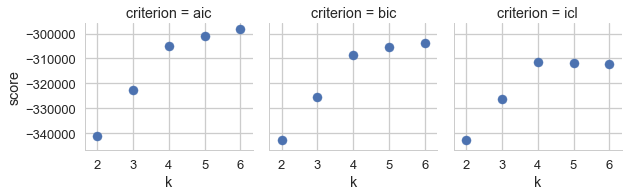

In [55]:
with sns.plotting_context('talk', font_scale=1):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=df.loc[df['criterion'].isin(['aic', 'bic', 'icl']),:], col='criterion', col_order=['aic', 'bic', 'icl'])
    g.map(plt.scatter, 'k', 'score')
plt.savefig('/Users/robert_arbon/Google Drive/Presentations/2018-04-20/results-tau{}.png'.format(tau),dpi=300, transparent=True)
#     for i, ax in enumerate(g.axes.flatten()):
#         idx = best['criterion']==criteria[i]
#         ax.scatter(best.loc[idx, 'k'],best.loc[idx, 'score'] , marker='o',s=50, color='k')
    # g.set(yscale='log')

In [ ]:
m = MaximumLikelihoodMSM(lag=tau, connectivity='largest', reversible=True )
m.fit(dtrajs)
hmm = MaximumLikelihoodHMSM(nstates=int(6), lag=tau, stationary=False, reversible=True, connectivity='largest', 
                           msm_init=m)
hmm.fit(dtrajs)

In [ ]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(6, sharex=True)
    for i, ax in enumerate(axes):
        ax.plot(hmm.metastable_distributions[ i,:]*25)
        ax.plot(hmm.stationary_distribution_obs*100)
        ax.set_ylabel('State {}'.format(i+1))

In [ ]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(6, sharex=True, sharey=True, figsize=(6,8))
    for i, ax in enumerate(axes):
        ax.plot(m.eigenvectors_right()[:,i+1])
        ax.plot(m.pi*100)
        ax.set_ylabel('State {}'.format(i+1))

In [ ]:
hmm.lifetimes

In [ ]:
mplt.plot_markov_model(P=hmm.P)

## Coarse graining - fixed n_sets

In [ ]:
# n=4
hmm = msm.coarse_grain(ncoarse=n)

In [ ]:
print(np.array2string(hmm.P*100, formatter={'float_kind':lambda x: "%.2f" % x}))

In [ ]:
ck = hmm.cktest(err_est=False, mlags=10, show_progress=False)
_ = mplt.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3)



In [ ]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(n, sharex=True)
    for i, ax in enumerate(axes):
        ax.plot(hmm.metastable_memberships[:, i])
        ax.plot(hmm.stationary_distribution_obs*100)
        ax.set_ylabel('State {}'.format(i+1))

In [ ]:
def forward(A, pobs, pi, T=None, alpha_out=None, dtype=np.float32):
    """Compute P( obs | A, B, pi ) and all forward coefficients.

    Parameters
    ----------
    A : ndarray((N,N), dtype = float)
        transition matrix of the hidden states
    pobs : ndarray((T,N), dtype = float)
        pobs[t,i] is the observation probability for observation at time t given hidden state i
    pi : ndarray((N), dtype = float)
        initial distribution of hidden states
    T : int, optional, default = None
        trajectory length. If not given, T = pobs.shape[0] will be used.
    alpha_out : ndarray((T,N), dtype = float), optional, default = None
        container for the alpha result variables. If None, a new container will be created.
    dtype : type, optional, default = np.float32
        data type of the result.

    Returns
    -------
    logprob : float
        The probability to observe the sequence `ob` with the model given
        by `A`, `B` and `pi`.
    alpha : ndarray((T,N), dtype = float), optional, default = None
        alpha[t,i] is the ith forward coefficient of time t. These can be
        used in many different algorithms related to HMMs.

    """
#     from decimal import Decimal as dec
    
    # set T
    if T is None:
        T = pobs.shape[0]  # if not set, use the length of pobs as trajectory length
    elif T > pobs.shape[0]:
        raise ValueError('T must be at most the length of pobs.')
    # set N
    N = A.shape[0]
    # initialize output if necessary
    if alpha_out is None:
        alpha_out = np.zeros((T, N), dtype=dtype)
    elif T > alpha_out.shape[0]:
        raise ValueError('alpha_out must at least have length T in order to fit trajectory.')
    # log-likelihood
#     logprob = dec(0.0)
    logprob = 0.0

    # initial values
    # alpha_i(0) = pi_i * B_i,ob[0]
    np.multiply(pi, pobs[0, :], out=alpha_out[0])

    # scaling factor
    scale = np.sum(alpha_out[0, :])
    # scale
    alpha_out[0, :] /= scale
#     logprob += dec(float(np.log(scale)))
    logprob += np.log(scale)
    
    # induction
    for t in range(T-1):
        # alpha_j(t+1) = sum_i alpha_i(t) * A_i,j * B_j,ob(t+1)
        np.multiply(np.dot(alpha_out[t, :], A), pobs[t+1, :], out=alpha_out[t+1])
        # scaling factor
        scale = np.sum(alpha_out[t+1, :])
        # scale
        alpha_out[t+1, :] /= scale

        # update logprob
#         logprob += dec(float(np.log(scale)))
        logprob += np.log(scale)


    return logprob, alpha_out

In [ ]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10)

In [ ]:
ks = np.arange(4,6)

In [ ]:
results = {'k': [], 'll': [], 'fold': []}

In [ ]:
for kdx, k in enumerate(ks):
    print(k)
    for idx, (train_idx, test_idx) in enumerate(cv.split(dtrajs)):
        train = [dtrajs[i] for i in train_idx]
        test = [dtrajs[i] for i in test_idx]
        print('\t', idx)
        # initialize MInit
        Minit = MaximumLikelihoodMSM(lag=tau)
        Minit.fit(train)

        # Map new trajectories
        ttrain = Minit.dtrajs_active
        ttest = []
        for x in test:
            try:
                ttest.append(Minit._full2active[x])
            except:
                pass
        ttest_lagged = lag_observations(ttest, lag=tau, stride=10)
        print(len(ttest_lagged))
        
        # Fit HMM
        M = MaximumLikelihoodHMSM(lag=tau, nstates=k, msm_init=Minit)
        M.fit(train)
        
        # get parameters
        obs_prob = M.observation_probabilities
        T = M.transition_matrix
        p0 = M.initial_distribution

        # Get log likelihood 
        loglik = 0
        for obs in ttest_lagged:
            p_obs = obs_prob[:, obs].T
            loglik += forward(T, p_obs, p0, dtype=np.longdouble)[0]
        results['ll'].append(loglik)
        results['k'].append(k)
        results['fold'].append(idx)

In [ ]:
# results = {'k': [], 'll': [], 'fold': []}
# ks = np.arange(2,5)


# for kdx, k in enumerate(ks):
#     print(k)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(dtrajs)):
#         train = [dtrajs[i] for i in train_idx]
#         test = [dtrajs[i] for i in test_idx]
#         print('\t', idx)

#         # Fit HMM
#         M = MaximumLikelihoodHMSM(lag=tau, nstates=k)
#         M.fit(train)
        
#         # Map new trajectories
#         ttest = []
#         for x in test:
#             try:
#                 ttest.append(M._full2active[x])
#             except:
#                 pass
#         ttest_lagged = lag_observations(ttest, lag=tau)
    
        
#         # get parameters
#         obs_prob = M.observation_probabilities
#         T = M.transition_matrix
#         p0 = M.initial_distribution

#         # Get log likelihood 
#         loglik = 0
#         for obs in ttest_lagged:
#             p_obs = obs_prob[:, obs].T
#             loglik += forward(T, p_obs, p0, dtype=np.longdouble)[0]
#         results['ll'].append(loglik)
#         results['k'].append(k)
#         results['fold'].append(idx)

In [ ]:
import pandas as pd
df = pd.DataFrame(results)

In [ ]:
df.tail(10)

In [ ]:
sns.boxplot(x='k', y='ll', data=df)

In [ ]:
plt.bar(ks, -df.groupby(['k']).aggregate(np.median)['ll'], width=0.5)
plt.yscale('log')

In [ ]:
g = sns.FacetGrid(data=df, hue='k')
g.map(sns.distplot, 'll', rug=True, hist=False).add_legend()

In [70]:
tau = 8
k = 2
hmm = MaximumLikelihoodHMSM(nstates=int(k), lag=tau, stationary=False, reversible=True, connectivity='largest')
hmm.fit(erg_dtrajs)

BIC/AIC not available for these constraints


MaximumLikelihoodHMSM(accuracy=0.001, connectivity='largest',
           dt_traj='1 step', lag=8, maxit=1000, mincount_connectivity=0.5,
           msm_init='largest-strong', nstates=2, observe_nonempty=True,
           reversible=True, separate=None, stationary=False, stride=1)

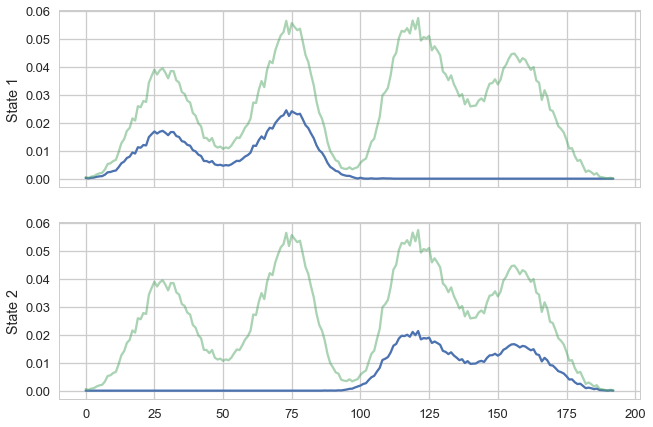

In [71]:
maxis = [np.argmax(hmm.metastable_distributions[ i,:]) for i in range(k)]
order = np.argsort(maxis)

with sns.plotting_context('talk', font_scale=1):
    fig, axes = plt.subplots(k, sharex=True)
    for i, ax in enumerate(axes):
        ax.plot(hmm.metastable_distributions[ order[i],:])
        ax.plot(hmm.stationary_distribution_obs*5, alpha=0.5)
        ax.set_ylabel('State {}'.format(order[i]+1))
plt.savefig('/Users/robert_arbon/Google Drive/Presentations/2018-04-20/states-tau{0}-k{1}.png'.format(tau, k),dpi=300, transparent=True)



In [72]:
h_probs = hmm.hidden_state_probabilities



In [76]:
h_probs[0].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])